<a href="https://colab.research.google.com/github/grace3999/USV_Python/blob/colab/Notebooks/6_xr_Annotations_deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install netcdf4

In [0]:
!pip install tensorboardcolab

In [0]:
import numpy as np
import pandas as pd
from os.path import join
from scipy import interpolate
import xarray as xr

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve

from sklearn.metrics import f1_score



#visualizing results
%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [0]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [0]:
#mount google drive containings required files: 1) csv of annotation features, 2) netcdf files
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#use shell commands to find file path for csv of annotation features
features_path = '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/feature_data_frames/annot_features_full.csv'
annot_features_data = pd.read_csv(features_path)
annot_features_full = pd.DataFrame(data = annot_features_data)
print(annot_features_full.shape)
#ensure no nans
print(annot_features_full.loc[pd.isna(annot_features_full['spec_pur'])].index)
annot_features_full.head()

(959, 13)
Int64Index([], dtype='int64')


,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll
0,0,527,cagepair,18922.5,high slug,44921.600,0.335974,40617.050954,117729.192000,6.831866,48.160918,0.000787,38586.198407
1,1,527,cagepair,24750.0,low slug,53212.637,0.295599,27042.548508,3827.200195,3.556462,20.402396,-0.000227,25690.421083
2,2,527,cagepair,56002.5,bbc,94253.766,0.189555,30090.095178,68103.292456,3.982554,18.393372,-0.002314,28585.590419
3,3,527,cagepair,174352.5,bbc,51008.836,0.306177,34324.170621,52563.703613,3.336529,10.448164,-0.001250,32607.962090
4,4,527,cagepair,342877.5,bbc,164846.110,0.144833,33090.921412,22861.514782,1.852232,3.185318,-0.001784,31436.375341


In [0]:
#create array of class labels, add to df
annot_labels = annot_features_full['Annotation']
annot_labels = annot_labels.replace(regex={r'low slug': 1, 'high slug': 1, 'low multi': 1, 'high multi': 1, 'bbc': 1, 'rand_noise': 0})
annot_features_full['class'] = annot_labels
annot_features_full.head()

,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll,class
0,0,527,cagepair,18922.5,high slug,44921.600,0.335974,40617.050954,117729.192000,6.831866,48.160918,0.000787,38586.198407,1
1,1,527,cagepair,24750.0,low slug,53212.637,0.295599,27042.548508,3827.200195,3.556462,20.402396,-0.000227,25690.421083,1
2,2,527,cagepair,56002.5,bbc,94253.766,0.189555,30090.095178,68103.292456,3.982554,18.393372,-0.002314,28585.590419,1
3,3,527,cagepair,174352.5,bbc,51008.836,0.306177,34324.170621,52563.703613,3.336529,10.448164,-0.001250,32607.962090,1
4,4,527,cagepair,342877.5,bbc,164846.110,0.144833,33090.921412,22861.514782,1.852232,3.185318,-0.001784,31436.375341,1


In [0]:
#separate and save for later testing dataset
#stratify splitting by annotation types
train_orig, test_orig = train_test_split(annot_features_full, test_size=0.3, random_state=1, stratify = annot_features_full.Annotation)
print(train_orig.shape)
print(test_orig.shape)
print(train_orig['Annotation'].value_counts())

(671, 14)
(288, 14)
rand_noise    560
low slug       42
bbc            31
high slug      19
low multi      16
high multi      3
Name: Annotation, dtype: int64


In [0]:
#separate and save for later testing dataset
train_validate, test_validate = train_test_split(train_orig, test_size=0.15, random_state=1, stratify = train_orig.Annotation)
print(train_validate.shape)
print(test_validate.shape)
print(train_validate['Annotation'].value_counts())
print(test_validate['Annotation'].value_counts())

(570, 14)
(101, 14)
rand_noise    476
low slug       36
bbc            26
high slug      16
low multi      14
high multi      2
Name: Annotation, dtype: int64
rand_noise    84
low slug       6
bbc            5
high slug      3
low multi      2
high multi     1
Name: Annotation, dtype: int64


In [0]:
#upsample minority class (upsample to an equal number of noise samples)
train_validate_maj = train_validate[train_validate['Annotation'] == 'rand_noise']
train_validate_min = train_validate[train_validate['Annotation'] != 'rand_noise']

train_validate_min_upsamples = resample(train_validate_min, replace=True, n_samples = len(train_validate_maj), random_state = 123)

train_validate_upsamples = pd.concat([train_validate_min_upsamples, train_validate_maj])

print(train_validate_upsamples.shape)
print(train_validate_upsamples['Annotation'].value_counts())

train_validate_upsamples.head()

(952, 14)
rand_noise    476
low slug      170
bbc           125
high slug      88
low multi      80
high multi     13
Name: Annotation, dtype: int64


,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll,class
124,124,556,cagepair,41512.5,bbc,283922.600,0.105281,35128.433948,27613.082970,1.746885,2.369667,-0.001916,33372.012250,1
49,49,535,CPApair,201847.5,low slug,114278.914,0.151498,16245.921214,18541.400530,5.060017,27.840860,-0.001240,15433.625153,1
131,131,556,cagepair,169807.5,high slug,47409.770,0.329336,30112.858088,13748.241415,6.074303,42.912236,-0.000247,28607.215183,1
137,137,556,cagepair,459967.5,high slug,88313.625,0.185218,34136.696251,175651.225991,6.314609,40.124449,-0.001435,32429.861439,1
147,147,557,cagepair,79177.5,bbc,121944.500,0.143545,31621.628971,96620.582439,3.463390,12.100880,-0.002297,30040.547522,1


In [0]:
def square_rgb(xr_slice):
    #takes in slice from netcdf file and reshapes to be compatible with keras pretrained model
    times = data['times'].values
    freqs = data['freq'].values
    
    #make square for Keras - need to interpolate data, first create function and then apply
    x = np.arange(0, len(times))
    y = np.arange(0, len(freqs))
    f = interpolate.interp2d(x, y, xr_slice.values)
    xnew = np.linspace(0, len(times), num=128)
    ynew = np.linspace(0, len(freqs), num=128)
    znew = f(xnew, ynew)

    X = np.log(znew)
    
    #normalize and change to rgba (remove a)
    X_colored = plt.cm.viridis((X - X.mean())/(X.max() - X.min()))
    X_colored = X_colored[:,:,:3]
    
    return X_colored

In [0]:
#create keras compatible image for each annotation in train data set, save as np array
rgbs = []
i = 1
for index, row in train_validate_upsamples.iterrows():
    data = xr.open_dataset('/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Fear/' + str(row['animal_number']) + '_' +  str(row['session']) + '_xr_Dataset.nc')
    
    xr_slice = data['__xarray_dataarray_variable__'].sel(slices=row['time_stamp'])
    
    rgb = square_rgb(xr_slice)
    
    rgbs.append(rgb)
    
X = np.stack(rgbs)*255
print(X.shape)

(952, 128, 128, 3)


In [0]:
y = train_validate_upsamples['class']
y.shape

(952,)

In [0]:
#create keras compatible image for each annotation in test data set, save as np array
rgbs_test = []
i = 1
for index, row in test_validate.iterrows():
    data = xr.open_dataset('/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Fear/' + str(row['animal_number'])  + '_' +  str(row['session']) + '_xr_Dataset.nc')
    
    xr_slice = data['__xarray_dataarray_variable__'].sel(slices=row['time_stamp'])
    
    rgb = square_rgb(xr_slice)

    rgbs_test.append(rgb)
    
X_test = np.stack(rgbs_test)*255
print(X_test.shape)

(101, 128, 128, 3)


In [0]:
y_test = test_validate['class']
y_test.shape

(101,)

In [0]:
import keras
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam

from keras.layers import Dropout, Activation
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

Using TensorFlow backend.


In [0]:
base_model=MobileNet(input_shape = (128,128,3), include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
#x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
#x=Dense(1024,activation='relu')(x) #dense layer 2
#x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(1,activation='sigmoid', name='features')(x) #final layer with softmax activation

In [0]:
model=Model(inputs=base_model.input,outputs=preds)

In [0]:
for layer in model.layers[:-1]:
    layer.trainable=False
for layer in model.layers[-1:]:
    layer.trainable=True

In [0]:
from keras import backend as K

# recall, precision and f1 functions (note that f1 calls the out of scope recall and precision functions)

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    r = true_positives / (possible_positives + K.epsilon())
    return r

    
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    p = true_positives / (predicted_positives + K.epsilon())
    return p

def f1(y_true, y_pred):
    
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    
    return 2*((p*r)/(p+r+K.epsilon()))

In [0]:
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=[f1, precision, recall])

In [0]:
batch_size = 64

In [0]:
# turning off the featurewise_center and the feature_std_normalization.
train_datagen=ImageDataGenerator(featurewise_center=False,
    featurewise_std_normalization=False, width_shift_range=0.2, fill_mode='reflect', preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow(X, y, batch_size=batch_size, shuffle=True)

In [0]:
# defining the validation generator: we need to apply the same preprocessing as the ones on the training set
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size, shuffle=True)

In [0]:
# it stopped working for Valentina

log_dir='/content/gdrive/Team Drives/USV_eScience_Incubator/Data/TF_logs/run_a'

with open(join(log_dir, 'metadata.tsv'), 'w') as f:
   f.write('Index\tLabel\n')
   for index,label in enumerate(y_test):
       f.write('%d\t%d\n' % (index,label))

#tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1, batch_size=32, write_graph=True, write_grads=False, write_images=True, embeddings_freq=1, embeddings_layer_names=['features'], embeddings_metadata=join(log_dir, 'metadata.tsv'), embeddings_data=X_test, update_freq='epoch')

tbc = TensorBoardColab()

callbacks_list = [
    EarlyStopping(monitor = 'val_acc', patience = 6, verbose = 1),
    ReduceLROnPlateau(monitor = 'val_acc', factor = 0.1, patience = 3, verbose = 1), [TensorBoardColabCallback(tbc)]]

Wait for 8 seconds...
TensorBoard link:
http://90ad257f.ngrok.io


In [0]:
# we will use the validation generator, not the test datasets directly

#step_size_train=train_generator.n//train_generator.batch_size

#model.fit_generator(generator=train_generator, steps_per_epoch=step_size_train,
#                   epochs=9,
#                   validation_data = [X_test, y_test],
#                callbacks=[TensorBoardColabCallback(tbc)])
#
#model.fit_generator(train_generator, steps_per_epoch=num_of_train_samples // batch_size, epochs=epochs, validation_data=validation_generator, validation_steps=num_of_test_samples // batch_size)

In [0]:
# stopped working for Valentina

# command for starting tensorboard from terminal

# !python -m tensorboard.main --logdir='/content/gdrive/Team Drives/USV_eScience_Incubator/Data/TF_logs/run_a/'

In [0]:
#ls /content/gdrive/Team\ Drives/USV_eScience_Incubator/Data/TF_logs/run_a

In [0]:
num_of_train_samples = X.shape[0]
num_of_test_samples = X_test.shape[0]
print(num_of_train_samples)

952


In [0]:
num_of_train_samples = X.shape[0]
num_of_test_samples = X_test.shape[0]
history = model.fit_generator(train_generator, steps_per_epoch=num_of_train_samples // batch_size, epochs=50, 
                    validation_data=validation_generator, validation_steps= num_of_test_samples // batch_size,
                    callbacks=[TensorBoardColabCallback(tbc)])

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
14/14 [==============================] - 5s 359ms/step - loss: 0.6521 - f1: 0.6478 - precision: 0.6711 - recall: 0.6544 - val_loss: 0.5806 - val_f1: 0.3810 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 2/50
14/14 [==============================] - 4s 260ms/step - loss: 0.5804 - f1: 0.7159 - precision: 0.7286 - recall: 0.7311 - val_loss: 0.5710 - val_f1: 0.2857 - val_precision: 0.2500 - val_recall: 0.3333
Epoch 3/50
14/14 [==============================] - 3s 237ms/step - loss: 0.5640 - f1: 0.7325 - precision: 0.7695 - recall: 0.7046 - val_loss: 0.6387 - val_f1: 0.4211 - val_precision: 0.2963 - val_recall: 0.7273
Epoch 4/50
14/14 [==============================] - 3s 248ms/step - loss: 0.4956 - f1: 0.7698 - precision: 0.7962 - recall: 0.7543 - val_loss: 0.6283 - val_f1: 0.3750 - val_precision: 0.3000 - val_recall: 0.5000
Epoch 5/50
14/14 [==============================] - 4s 251ms/step - loss: 0.4573 - f1: 0.7867 - precisio

Saving the model and its weights.

In [0]:
#from keras.models import model_from_json
## serialize model to JSON
#model_json = model.to_json()
#with open("model.json", "w") as json_file:
#    json_file.write(model_json)
# serialize weights to HDF5
#model.save_weights("model.h5")
#print("Saved model to disk")
 
# later...
 
# load json and create model
#json_file = open('model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)
# load weights into new model
#loaded_model.load_weights("model.h5")
#print("Loaded model from disk")
 
# evaluate loaded model on test data
#loaded_model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=[f1,precision,recall])
#score = loaded_model.evaluate(X, y, verbose=0)
#print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))


**Performance on the Validation Set**

In [0]:
#Confusion Matrix and Classification Report
X_test_temp = X_test.copy()
Y_pred = model.predict(preprocess_input(X_test_temp))
y_pred = (Y_pred>0.5)

In [0]:
score = model.evaluate(X_test_temp,y_test)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

101/101 [==============================] - 0s 1ms/step
f1: 42.55%


In [0]:
print(Y_pred.shape)
print(y_test.shape)

(101, 1)
(101,)


No handles with labels found to put in legend.


Text(0.5, 1.0, 'Precision-Recall Curve')

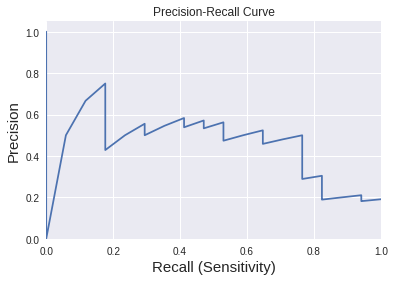

In [0]:
p, r, thresholds = precision_recall_curve(y_test, Y_pred)
plt.plot(r, p)

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('Recall (Sensitivity)', fontsize = 15)
plt.ylabel('Precision', fontsize = 15)
plt.title('Precision-Recall Curve')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'ROC Curve')

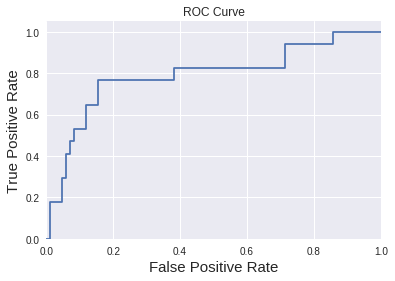

In [0]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, Y_pred)
plt.plot(fpr, tpr)

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate', fontsize = 15)
plt.ylabel('True Positive Rate', fontsize = 15)
plt.title('ROC Curve')

In [0]:
# define the plot_confusion_matrix function
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



Confusion matrix, without normalization
[[55 29]
 [ 4 13]]


Text(0.5, 1.0, 'Validation F1 Score: 0.44')

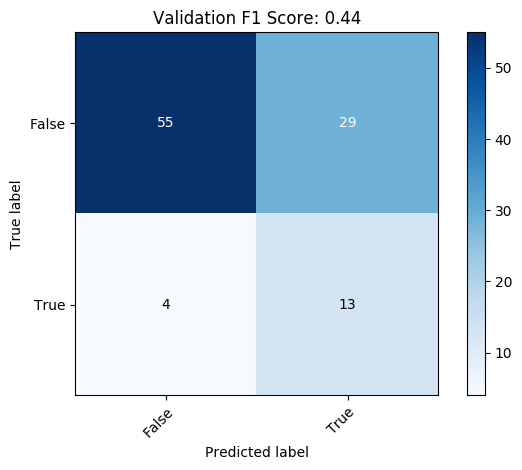

In [0]:
plt.style.use('default')
plot_confusion_matrix(list(y_test), y_pred.flatten(),unique_labels(y_pred.flatten(),list(y_test)))
plt.title('Validation F1 Score: ' + str(round(f1_score(y_test,y_pred),2)))

Let's compare with the training set performance.

In [0]:

#Confusion Matrix and Classification Report
X_temp = X.copy()
Y_pred = model.predict(preprocess_input(X_temp))
y_pred = (Y_pred>0.5)

Confusion matrix, without normalization
[[332 144]
 [ 95 381]]


Text(0.5, 1.0, 'Train F1 Score: 0.76')

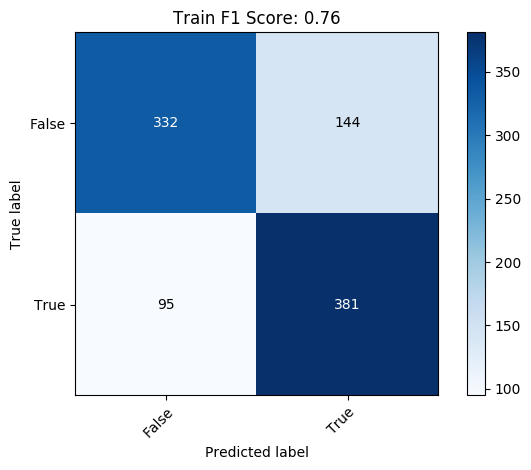

In [0]:
plot_confusion_matrix(list(y), y_pred.flatten(),unique_labels(y_pred.flatten(),list(y_test)))
plt.title('Train F1 Score: ' + str(round(f1_score(y,y_pred)*100)/100))

Text(0.5, 0, 'Iteration')

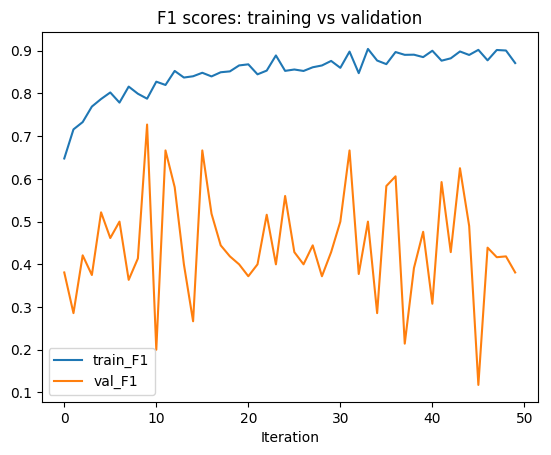

In [0]:
line2 = plt.plot(history.history['f1'],label = 'train_F1')
line1 = plt.plot(history.history['val_f1'],label = 'val_F1')

plt.title('F1 scores: training vs validation')
#plt.legend((line1, line2), ('train_F1','val_F1'))
plt.legend()
plt.xlabel('Iteration')